# Floored cliquet options

Let $T$ be a future point in time and divide the interval $\left[0, T\right]$ into $N$ subintervals called reset periods of length $\Delta_n = T_n − T_{n−1}$, where $\{ T_n \}^ N_{n=0}$, $T_0 = 0$, $T_N = T$ are called the reset days. 

The return of an asset with price process $S_t$ over a reset period $\left[T_{n−1}, T_n\right)$ is then defined as

$$R_n = \frac{S_{T_n}}{S_{T_{n-1}}} - 1$$

Additionally the *truncated returns* is defined as:

$$\bar{R_n} = \max \left( \min \left(R_n, C\right), F\right)$$

where $F$ and $C$ are the floor and cap levels respectively (absence of floor and caps corresponds to $F=-1$ and $C=+\infty$).

The  *truncated returns* is represented by:

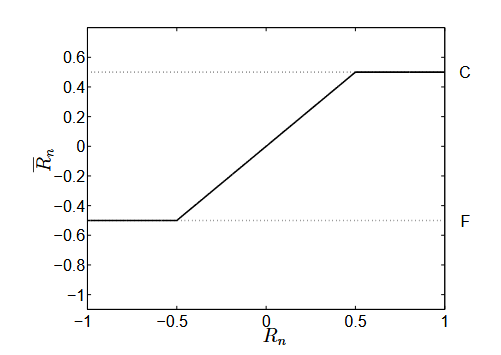


A general cliquet option has a payoff $Y$ at time $T$ of:

$$Y = \min\left( \max \left(\sum_{n=1}^N \bar{R_n}, F_g\right), C_g \right)$$

where the global floor $F_g$ and global cap $C_g$ are minimum and maximum returns respectively.

In [1]:
import sys
sys.path.append("../../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qat.lang.AQASM as qlm
from copy import deepcopy
%matplotlib inline

In [2]:
#This cell loads the QLM solver. See notebook: 00_AboutTheNotebooksAndQPUs.ipynb
from QQuantLib.qpu.get_qpu import get_qpu
# myqlm qpus: python, c
# QLM qpus accessed using Qaptiva Access library: qlmass_linalg, qlmass_mps
# QLM qpus: Only in local Quantum Learning Machine: linalg, mps
my_qpus = ["python", "c", "qlmass_linalg", "qlmass_mps", "linalg", "mps"]

linalg_qpu = get_qpu(my_qpus[1])

## 1. Getting the Paths

To evaluate the final payoff for a cliquet option the first thing we need to build the possible paths the *asset* can follow from one reset day to the other (for all the reset days we want to evaluate the option). These paths will be build under the **Black-Scholes** model. 

For each posible reset day we need to define a domain discretization of the asset in the following way:

* For the initial reset day we need only the initial value of the asset.
* For the second reset day we are going to compute $N$ possible paths that starts at the initial reset day.
* For the third reset day we are going to build $N$ possible paths for each of the values of the asset at second reset day. So at this day we are going to have $N^2$ possible paths.


For each new reset day we need to build $N$ new paths for each possible value for the before reset day. If there are $m$ reset days then at the end reset day we will have $N^m$ possible paths.

To build this scheme the *bs_tree* function from **QQuantLib.finance.classical_finance** module will be used. The inputs of the function are :

* s_0: initial value of the asset
* risk_free_rate: risk free needed rate for building a **Black-Scholes** evolution of the asset.
* volatility: volatility of the asset needed for for building a **Black-Scholes** evolution of the asset.
* times: list with the reset days we want to compute
* discretization : number of points for the discretization of the domain
* bounds: for truncating the probability density


The *bs_tree* returns the following two objects:

* s_t: list with all the posible discretization values of the asset for each reset day (tree format)
* p_t: list with all the probabilities for all the different built paths between the initial and the final reset day.


In [3]:
from QQuantLib.finance.classical_finance import bs_tree

In [4]:
#Initial value for the asset
s_0 = 1.0
risk_free_rate = 0.03
volatility = 0.4
reset_dates = np.array([0.0, 1.0, 2.0])

#Discretization: 2^n_qbits
n_qbits = 5

tree_s, bs_path_prob = bs_tree(
    s_0=s_0,
    risk_free_rate=risk_free_rate, 
    volatility=volatility,
    times=reset_dates,
    discretization= 2**n_qbits,
    bounds = 7
)

TypeError: bs_tree() missing 3 required positional arguments: 'maturity', 'number_samples', and 'time_steps'

The first return of *bs_tree* (*tree_s* variable) contains the possible values of the asset for each reset day.

The first element of the *tree_s* is the initial value of the asset. The second element are the posible asset values at the second reset day. 

In [ ]:
# First reset day 
tree_s[0]

In [ ]:
# Second reset day: MUST have 2^n_qbits values
print(len(tree_s[1]))

The third element has the values of the asset at the third reset day for each posible value of the second reset day. So it has 2^n_qbits * 2^n_qbits values

In [ ]:
print(len(tree_s[2]))

The firsts $2^n$ values of the third element of the *tree_s* contains the posible asset values for the first asset value of the second step and so on.

In [ ]:
print("Possible asset values in third reset day: \n{}".format(
    tree_s[2][:2**n_qbits]))
print("For first asset value {} in second reset day: ".format(tree_s[1][0]))

In [ ]:
print("Possible asset values in third reset day: \n{}".format(
    tree_s[2][2**n_qbits: 2*2**n_qbits]))
print("For second asset value {} in second reset day: ".format(tree_s[1][1]))

The *tree_to_paths* function from **QQuantLib.finance.classical_finance** module transform the *tree_s* variable to a table format where all the possible paths of the asset are stored for each reset day:

In [ ]:
from QQuantLib.finance.classical_finance import tree_to_paths

In [ ]:
# Posible path of the assets along the three reset days
paths_s = tree_to_paths(tree_s)
pdf = pd.DataFrame(paths_s, index=["reset_day0", "reset_day1", "reset_day2"])

In [ ]:
pdf

In [ ]:
# Possible paths for the asset
for i in range(len(pdf.columns)):
    plt.plot(pdf[i], 'o-')

The variable *bs_path_prob* (the second output of the *bs_tree*) is a list where element contains the probability of the built paths for each reset day. The last element will contain the probability of all the built paths from the initial reset day to the last one.

In [ ]:
bs_path_prob

In [ ]:
# Probabilities for all the built paths from initial to last reset day
plt.plot(bs_path_prob[-1])
plt.xlabel("Paths")
plt.ylabel("Probability")

## 2. Getting the Cliquet Option payoff

For each built path we need to compute the associated payoff of the cliquet option. This can be done using the *cliquet_cashflows* from **QQuantLib.finance.classical_finance**. The inputs are:

* local_cap: $C$
* local_floor: $F$
* global_cap: $C_g$
* global_floor: $F_g$
* paths: the built paths from *tree_to_paths* function

The return is the cliquet payoff for each posible path from initial reset day to the last one.

In [ ]:
from QQuantLib.finance.classical_finance import cliquet_cashflows

In [ ]:
local_cap = 0.1
local_floor = -0.1
global_cap = 0.2
global_floor = -0.2

In [ ]:
cliqet_payoffs = cliquet_cashflows(
    local_cap = local_cap,
    local_floor = local_floor,
    global_cap = global_cap,
    global_floor = global_floor,
    paths=paths_s
)

In [ ]:
# Cliquet Pay Off for each built path
plt.plot(cliqet_payoffs)
plt.xlabel("Paths")
plt.ylabel("Cliquet PayOffs")

## 3. The return of the Cliquet option

Now we can compute the return of the cliquet option by computing the expected value of the probability of all the paths and the corresponding payoff

In [ ]:
cliquet_return = np.dot(bs_path_prob[-1],cliqet_payoffs)

print("Expected return of the cliquet at the last reset day: {}".format(
    cliquet_return
))

We need to discount the risk free rate as usual for know the return at the initial day:

In [ ]:
final_return = np.exp(-risk_free_rate * reset_dates[-1]) * cliquet_return

print("Final Return: {}".format(final_return))

## 4. Cliquet Option using *q_solve_integral*

The *Cliquet* option return can be computed easily using the *q_solve_integral* function from **QQuantLib.finance.quantum_integration** (see *10_ApplicationTo_Finance_01_IntegralComputing.ipynb*). 

We only need to provide the probability and the payoff array functions and configure properly  the **AE** algorithm

In [ ]:
from QQuantLib.finance.quantum_integration import q_solve_integral

In [ ]:
#probability definition
p_x = bs_path_prob[-1]
#probability normalisation
p_x_normalisation = np.sum(p_x)
norm_p_x = p_x / p_x_normalisation

#Function definition
f_x = cliqet_payoffs
f_x_normalisation = np.max(np.abs(f_x))
norm_f_x = f_x / f_x_normalisation

In [ ]:
ae_dict = {
    #QPU
    'qpu': linalg_qpu,
    #Multi controlled decomposition
    'mcz_qlm': False, 
    
    #shots
    'shots': None,
    
    #MLAE
    'schedule': None,
    'delta' : None,
    'ns' : None,
    
    #CQPEAE
    'auxiliar_qbits_number': None,
    "window" : None,  
    "kaiser_alpha" : None,
    #IQPEAE
    'cbits_number': None,
    #IQAE & RQAQE
    'epsilon': None,
    #IQAE
    'alpha': None,
    #RQAE
    'gamma': None,
    'q': None,
    #For encoding class
    "multiplexor": True
}

In [ ]:
ae_dict.update({
    "array_function":norm_f_x,
    "array_probability": norm_p_x,
})

# PayOff can be positive and negative so better use encoding 2
ae_dict.update({"encoding" : 2})

### 4.1 IQAE

In [ ]:
ae_dict.update({
    "ae_type" : "IQAE",
    "epsilon" : 0.001,
    "alpha" : 0.05,
    "shots" : 100
})

In [ ]:
%%time
iqae_solution, iqae_object = q_solve_integral(**ae_dict)

In [ ]:
iqae_solution * f_x_normalisation * p_x_normalisation

### 4.2 RQAE

In [ ]:
%%time
ae_dict.update({
    "ae_type" : "RQAE",
    "epsilon" : 0.001,
    "gamma" : 0.05,
    "q" : 1.2
})
rqae_solution, rqae_object = q_solve_integral(**ae_dict)

In [ ]:
q_cliquet_return = rqae_solution * f_x_normalisation * p_x_normalisation

In [ ]:
q_cliquet_return

In [ ]:
(cliquet_return < q_cliquet_return["ae_u"]) & (cliquet_return > q_cliquet_return["ae_l"])

In [ ]:
rqae_solution

## 5. ae_clique_return_estimation

The *ae_clique_return_estimation* function allows the user compute a cliquet option by configuring an input dictionary:


In [ ]:
from QQuantLib.finance.cliqet_return_estimation import ae_clique_return_estimation

In [ ]:
#Base AE configuration dictionary
ae_dict = {
    #QPU
    'qpu': linalg_qpu,
    #Multi controlled decomposition
    'mcz_qlm': False, 
    
    #shots
    'shots': None,
    
    #MLAE
    'schedule': None,
    'delta' : None,
    'ns' : None,
    
    #CQPEAE
    'auxiliar_qbits_number': None,
    "window" : None,  
    "kaiser_alpha" : None,
    #IQPEAE
    'cbits_number': None,
    #IQAE & RQAQE
    'epsilon': None,
    #IQAE
    'alpha': None,
    #RQAE
    'gamma': None,
    'q': None,
    #For encoding class
    "multiplexor": True
}

In [ ]:
# Asset configuration
asset_config = {
    "n_qbits" : n_qbits,
    "s_0": s_0,
    "risk_free_rate" : risk_free_rate,
    "volatility" : volatility,
    "reset_dates" : [0.0, 1.0, 2.0],
    "bounds": 7
}

#Cliquet option configuration
option_config = {
    "local_cap" : local_cap,
    "local_floor" : local_floor,
    "global_cap" : global_cap,
    "global_floor": global_floor
}

other_configuration = {
    'qpu': linalg_qpu,
    "save": False,
    "file_name": "./ae_problem.csv",
    "number_of_tests": 1
}

ae_dict.update(asset_config)
ae_dict.update(option_config)
ae_dict.update(other_configuration)
ae_dict.update({"encoding" : 2})

In [ ]:
ae_dict.update({
    "ae_type" : "IQAE",
    "epsilon" : 0.001,
    "alpha" : 0.05,
    "shots" : 100
})

In [ ]:
pdf = ae_clique_return_estimation(**ae_dict)

In [ ]:
# Asset configuration
pdf[[
    "n_qbits", "s_0", "risk_free_rate", "volatility","bounds",
    "reset_dates"
]]

In [ ]:
pdf[[
    "local_cap", "local_floor", "global_cap", "global_floor"
]]

In [ ]:
#ae configuration
pdf[[
    'ae_type','schedule', 'delta', 'ns', 
    'auxiliar_qbits_number', 'cbits_number',
    'epsilon', 'alpha', 'gamma', 'q', 'shots',
    'mcz_qlm', 'encoding','multiplexor',
]]

In [ ]:
pdf[['payoff_normalisation', 'p_x_normalisation']]

In [ ]:
pdf[[
    "ae_l_expectation", "ae_expectation", 
    "ae_u_expectation", "riemann_expectation", "absolute_error"
]]

In [ ]:
pdf[['finance_exact_price', 'finance_riemann_price', 
     'finance_price_estimation', 'finance_error_riemann', 'finance_error_exact'
]]

In [ ]:
ae_dict.update({
    "ae_type" : "RQAE",
    "epsilon" : 0.001,
    "gamma" : 0.05,
    "q" : 1.2
})
pdf = ae_clique_return_estimation(**ae_dict)

In [ ]:
pdf["riemann_expectation"] > pdf["ae_l_expectation"]

In [ ]:
pdf["riemann_expectation"] < pdf["ae_u_expectation"]

In [ ]:
pdf